Chirag walia

25/Afi/15

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [ ]:
transform_cifar = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_cifar = datasets.CIFAR10(
    root="./data",
    train=True,
    transform=transform_cifar,
    download=True
)

test_cifar = datasets.CIFAR10(
    root="./data",
    train=False,
    transform=transform_cifar,
    download=True
)

train_loader_cifar = DataLoader(train_cifar, batch_size=64, shuffle=True)
test_loader_cifar = DataLoader(test_cifar, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:04<00:00, 35.5MB/s]


In [ ]:
class CNN(nn.Module):
    def __init__(self, activation_fn):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            activation_fn,
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            activation_fn,
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            activation_fn,
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
def initialize_weights(model, init_type):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if init_type == "xavier":
                nn.init.xavier_uniform_(m.weight)
            elif init_type == "kaiming":
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
            elif init_type == "random":
                nn.init.normal_(m.weight, mean=0, std=0.01)


In [ ]:
activations = {
    "relu": nn.ReLU(),
    "tanh": nn.Tanh(),
    "leaky_relu": nn.LeakyReLU(0.01)
}

In [ ]:
def get_optimizer(optimizer_name, model):
    if optimizer_name == "sgd":
        return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_name == "adam":
        return optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == "rmsprop":
        return optim.RMSprop(model.parameters(), lr=0.001)


In [ ]:
def train(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        acc = evaluate(model, test_loader)
        test_accuracies.append(acc)

        print(f"Epoch [{epoch+1}/{epochs}]  Loss: {avg_loss:.4f}  Accuracy: {acc:.2f}%")

    return train_losses, test_accuracies


In [ ]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [ ]:
history = {}
models = {}

for act_name, act_fn in activations.items():
    for init in ["xavier", "kaiming", "random"]:
        for opt in ["sgd", "adam", "rmsprop"]:
            key = (act_name, init, opt)
            print(f"\nTraining Model: {key}")

            model = CNN(act_fn).to(device)
            initialize_weights(model, init)

            optimizer = get_optimizer(opt, model)
            criterion = nn.CrossEntropyLoss()

            losses, accuracies = train(
                model,
                train_loader_cifar,
                test_loader_cifar,
                optimizer,
                criterion,
                epochs=20
            )

            models[key] = model
            history[key] = {
                "loss": losses,
                "accuracy": accuracies
            }


Training Model: ('relu', 'xavier', 'sgd')
Epoch [1/20]  Loss: 1.8347  Accuracy: 44.81%
Epoch [2/20]  Loss: 1.5613  Accuracy: 51.55%
Epoch [3/20]  Loss: 1.3631  Accuracy: 56.56%
Epoch [4/20]  Loss: 1.2216  Accuracy: 61.72%
Epoch [5/20]  Loss: 1.1513  Accuracy: 64.36%
Epoch [6/20]  Loss: 1.0854  Accuracy: 66.21%
Epoch [7/20]  Loss: 1.0495  Accuracy: 67.79%
Epoch [8/20]  Loss: 1.0184  Accuracy: 68.02%
Epoch [9/20]  Loss: 0.9899  Accuracy: 69.36%
Epoch [10/20]  Loss: 0.9570  Accuracy: 70.39%
Epoch [11/20]  Loss: 0.9375  Accuracy: 71.47%
Epoch [12/20]  Loss: 0.9204  Accuracy: 70.88%
Epoch [13/20]  Loss: 0.9016  Accuracy: 71.40%
Epoch [14/20]  Loss: 0.8871  Accuracy: 72.14%
Epoch [15/20]  Loss: 0.8675  Accuracy: 71.83%
Epoch [16/20]  Loss: 0.8605  Accuracy: 71.65%
Epoch [17/20]  Loss: 0.8471  Accuracy: 71.47%
Epoch [18/20]  Loss: 0.8375  Accuracy: 72.17%
Epoch [19/20]  Loss: 0.8242  Accuracy: 74.89%
Epoch [20/20]  Loss: 0.8190  Accuracy: 74.65%

Training Model: ('relu', 'xavier', 'adam')
Ep

In [ ]:
results = {}
for key, metrics in history.items():
    results[key] = max(metrics["accuracy"])

best_config = max(results, key=results.get)
best_accuracy = results[best_config]

print("Best Configuration:")
print(f"Activation   : {best_config[0]}")
print(f"Init Method  : {best_config[1]}")
print(f"Optimizer    : {best_config[2]}")
print(f"Accuracy (%) : {best_accuracy:.2f}")

Best Configuration:
Activation   : relu
Init Method  : random
Optimizer    : adam
Accuracy (%) : 76.14


In [ ]:
os.makedirs("saved_models", exist_ok=True)
for key, model in models.items():
    act, init, opt = key
    filename = f"cnn_{act}_{init}_{opt}.pth"
    torch.save(model.state_dict(), os.path.join("saved_models", filename))

In [ ]:
!zip -r models.zip /content/saved_models/*

  adding: content/saved_models/cnn_leaky_relu_kaiming_adam.pth (deflated 7%)
  adding: content/saved_models/cnn_leaky_relu_kaiming_rmsprop.pth (deflated 7%)
  adding: content/saved_models/cnn_leaky_relu_kaiming_sgd.pth (deflated 7%)
  adding: content/saved_models/cnn_leaky_relu_random_adam.pth (deflated 7%)
  adding: content/saved_models/cnn_leaky_relu_random_rmsprop.pth (deflated 7%)
  adding: content/saved_models/cnn_leaky_relu_random_sgd.pth (deflated 7%)
  adding: content/saved_models/cnn_leaky_relu_xavier_adam.pth (deflated 7%)
  adding: content/saved_models/cnn_leaky_relu_xavier_rmsprop.pth (deflated 7%)
  adding: content/saved_models/cnn_leaky_relu_xavier_sgd.pth (deflated 7%)
  adding: content/saved_models/cnn_relu_kaiming_adam.pth (deflated 7%)
  adding: content/saved_models/cnn_relu_kaiming_rmsprop.pth (deflated 7%)
  adding: content/saved_models/cnn_relu_kaiming_sgd.pth (deflated 7%)
  adding: content/saved_models/cnn_relu_random_adam.pth (deflated 7%)
  adding: content/save

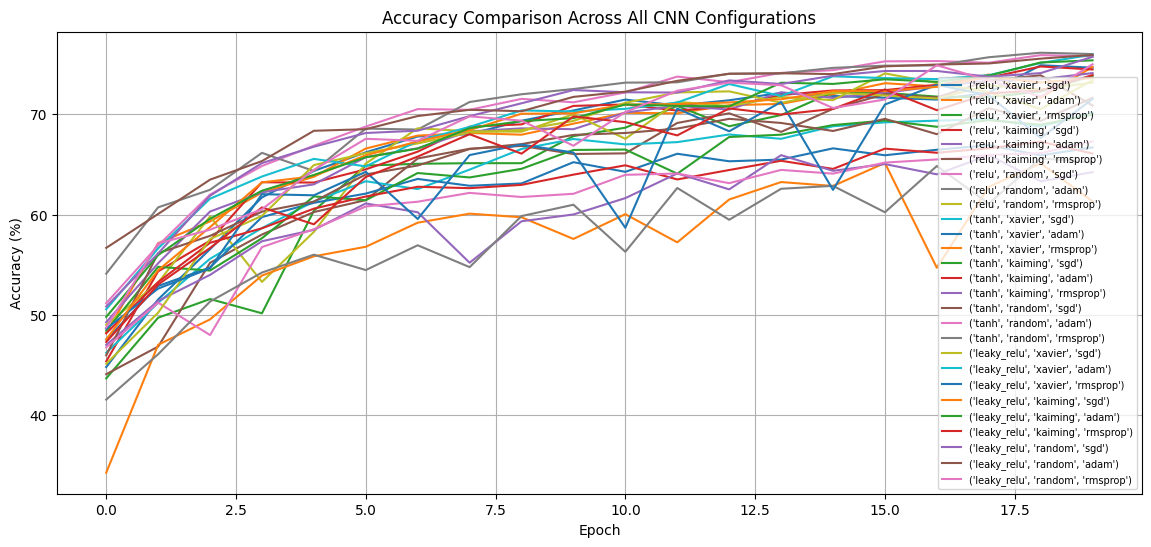

In [ ]:
plt.figure(figsize=(14, 6))
for key, metrics in history.items():
    plt.plot(metrics["accuracy"], label=str(key))

plt.title("Accuracy Comparison Across All CNN Configurations")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(fontsize=7, loc="best")
plt.grid(True)
plt.show()

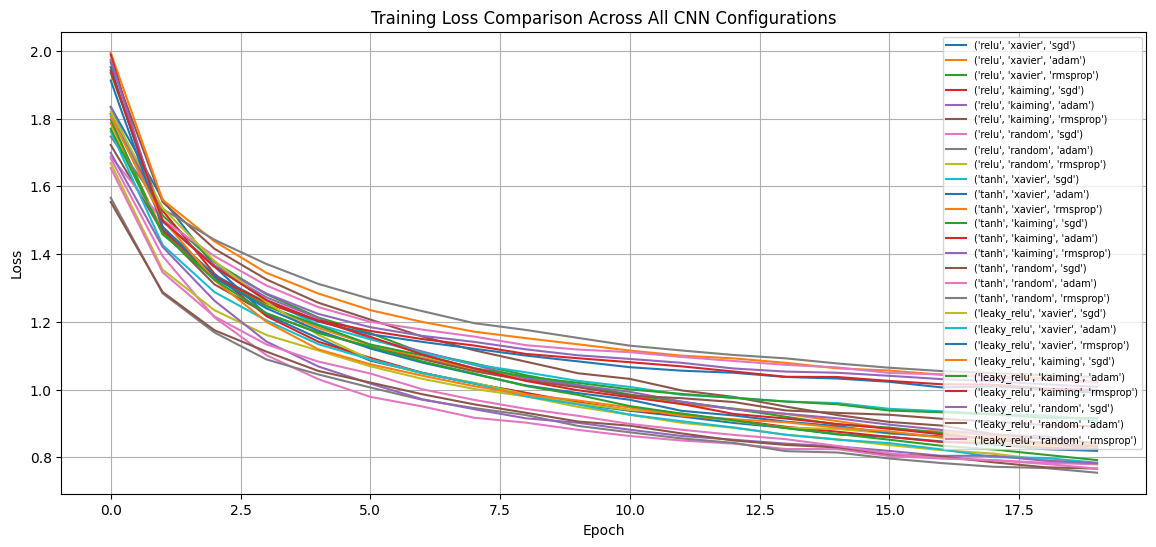

In [ ]:
plt.figure(figsize=(14, 6))

for key, metrics in history.items():
    plt.plot(metrics["loss"], label=str(key))

plt.title("Training Loss Comparison Across All CNN Configurations")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize=7, loc="best")
plt.grid(True)
plt.show()

In [ ]:
import torchvision.models as tv_models

resnet18 = tv_models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False

resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
resnet18 = resnet18.to(device)

resnet_optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

resnet_losses, resnet_accuracies = train(
    resnet18,
    train_loader_cifar,
    test_loader_cifar,
    resnet_optimizer,
    criterion,
    epochs=20
)

resnet_key = ("resnet18", "pretrained", "adam")

models[resnet_key] = resnet18
history[resnet_key] = {
    "loss": resnet_losses,
    "accuracy": resnet_accuracies
}

results[resnet_key] = max(resnet_accuracies)
torch.save(resnet18.state_dict(), "saved_models/resnet18_cifar10.pth")

print("ResNet-18 training complete.")
print(f"Best Accuracy: {results[resnet_key]:.2f}%")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


Epoch [1/20]  Loss: 1.8319  Accuracy: 39.40%
Epoch [2/20]  Loss: 1.7319  Accuracy: 40.49%
Epoch [3/20]  Loss: 1.7132  Accuracy: 40.27%
Epoch [4/20]  Loss: 1.7138  Accuracy: 40.24%
Epoch [5/20]  Loss: 1.7070  Accuracy: 40.11%
Epoch [6/20]  Loss: 1.7034  Accuracy: 40.83%
Epoch [7/20]  Loss: 1.7030  Accuracy: 41.09%
Epoch [8/20]  Loss: 1.7047  Accuracy: 40.92%
Epoch [9/20]  Loss: 1.7027  Accuracy: 41.64%
Epoch [10/20]  Loss: 1.7077  Accuracy: 40.35%
Epoch [11/20]  Loss: 1.7072  Accuracy: 40.68%
Epoch [12/20]  Loss: 1.7002  Accuracy: 41.19%
Epoch [13/20]  Loss: 1.7011  Accuracy: 40.09%
Epoch [14/20]  Loss: 1.7014  Accuracy: 40.66%
Epoch [15/20]  Loss: 1.7105  Accuracy: 40.45%
Epoch [16/20]  Loss: 1.7080  Accuracy: 41.26%
Epoch [17/20]  Loss: 1.7093  Accuracy: 41.85%
Epoch [18/20]  Loss: 1.7013  Accuracy: 41.64%
Epoch [19/20]  Loss: 1.6986  Accuracy: 40.83%
Epoch [20/20]  Loss: 1.7028  Accuracy: 41.32%
ResNet-18 training complete.
Best Accuracy: 41.85%


In [ ]:
best_cnn_history = history[best_config]
resnet_history = history[("resnet18", "pretrained", "adam")]

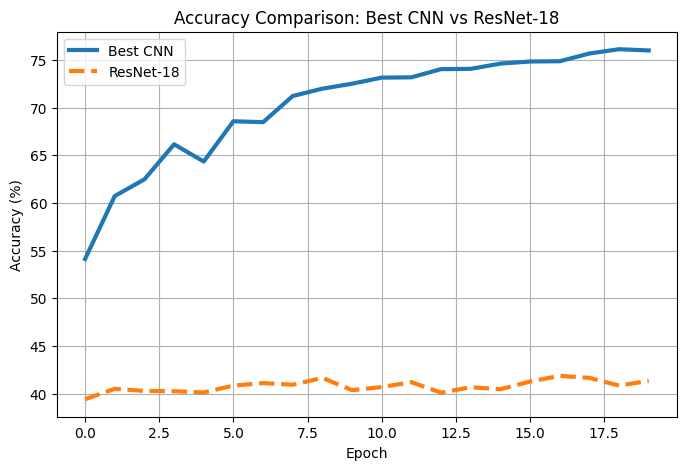

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(best_cnn_history["accuracy"], label="Best CNN", linewidth=3)
plt.plot(resnet_history["accuracy"], label="ResNet-18", linewidth=3, linestyle="--")
plt.title("Accuracy Comparison: Best CNN vs ResNet-18")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

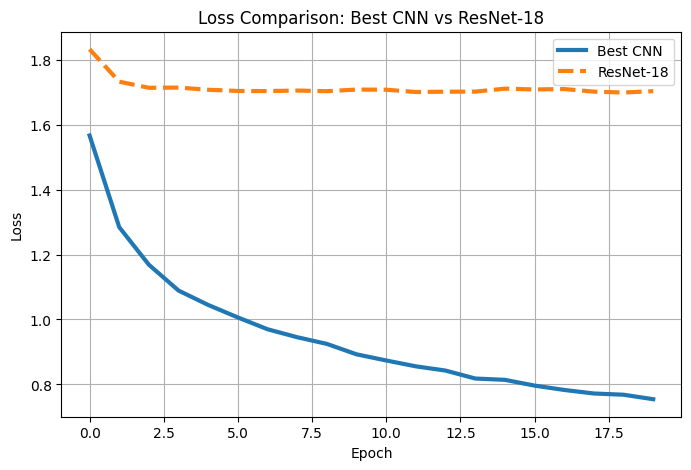

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(best_cnn_history["loss"], label="Best CNN", linewidth=3)
plt.plot(resnet_history["loss"], label="ResNet-18", linewidth=3, linestyle="--")
plt.title("Loss Comparison: Best CNN vs ResNet-18")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()